In [1]:
!pip install mlxtend torch-summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.10.1 which is incompatible.


In [2]:
import os
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam , lr_scheduler 
import torchvision 
from torchvision import datasets 
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from PIL import Image

from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score 
from sklearn.model_selection import train_test_split 


import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
dir = r'/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'

file_paths = []
labels = []


for root, dirs, files in os.walk(dir):
    for classs in dirs:
        if classs in ["lung_image_sets", "colon_image_sets"]:
            continue  # Skip the main classes, only consider subclasses
        class_path = os.path.join(root, classs)
        flist = os.listdir(class_path)
        for f in flist:
            fpath = os.path.join(class_path, f)
            file_paths.append(fpath)
            labels.append(classs)

Fseries = pd.Series(file_paths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  

print(df['labels'].value_counts())

labels
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64


In [5]:
sample_size=5000 # each folder sample size
sample_list=[]
group=df.groupby('labels')
for label in df['labels'].unique():    
    label_group=group.get_group(label).sample(sample_size, replace=False, random_state=42, axis=0)    
    sample_list.append(label_group)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))

25000


In [6]:
categories=[]
classes=[]
for cat in tqdm(os.listdir(dir)) : 
    if cat not in categories : 
        categories.append(cat.replace('_image_sets',''))
        
    for folder in os.listdir(dir + "/" + cat) : 
        if folder not in classes : 
            classes.append(folder)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
classes,categories

(['colon_aca', 'colon_n', 'lung_aca', 'lung_scc', 'lung_n'], ['colon', 'lung'])

In [8]:
from sklearn.model_selection import train_test_split

# Splitting 80% training and 20% testing
train_path_list, test_path_list, train_labels, test_labels = train_test_split(
    file_paths, 
    labels, 
    train_size=0.80, 
    random_state=42
)

# Check the lengths of each split
print(f'Number of training samples: {len(train_path_list)}')
print(f'Number of testing samples: {len(test_path_list)}')


Number of training samples: 20000
Number of testing samples: 5000


In [9]:
class InvalidDatasetException(Exception):
    def __init__(self, len_of_paths, len_of_labels):
        super().__init__(f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})")

In [10]:
class TrainData(Dataset):
    def __init__(self, train_path, train_label, transform_method):
        self.train_path = train_path
        self.train_label = train_label
        self.transform_method = transform_method

        # Validate if paths and labels are of the same length
        if len(self.train_path) != len(self.train_label):
            raise InvalidDatasetException(len(self.train_path), len(self.train_label))

    def __len__(self):
        return len(self.train_path)

    def __getitem__(self, index):
        image = Image.open(self.train_path[index])
        tensor_image = self.transform_method(image)
        label = self.train_label[index]

        return tensor_image, label

In [11]:
img_size=250

transform=transforms.Compose([
     transforms.Resize(size=(img_size,img_size)) , 
     transforms.ToTensor()
 ])


In [12]:
train_dataset = TrainData(train_path=train_path_list, train_label=train_labels, transform_method=transform)

In [13]:
len(train_dataset)

20000

In [14]:
x = train_dataset.__getitem__(5)
x[0].shape

torch.Size([3, 250, 250])

In [15]:
class TestData(Dataset):
    def __init__(self, test_path, test_label, transform_method):
        self.test_path = test_path
        self.test_label = test_label
        self.transform_method = transform_method

        # Validate if paths and labels are of the same length
        if len(self.test_path) != len(self.test_label):
            raise InvalidDatasetException(len(self.test_path), len(self.test_label))

    def __len__(self):
        return len(self.test_path)

    def __getitem__(self, index):
        image = Image.open(self.test_path[index])
        tensor_image = self.transform_method(image)
        label = self.test_label[index]

        return tensor_image, label

In [16]:
test_dataset = TestData(test_path=test_path_list, test_label=test_labels, transform_method=transform)

In [17]:
len(test_dataset)

5000

In [18]:
x = test_dataset.__getitem__(5)
x[0].shape

torch.Size([3, 250, 250])

In [19]:
BATCH_SIZE = 128

In [20]:
torch.manual_seed(42)
train_dataloader=DataLoader(
    dataset=train_dataset , 
    batch_size = BATCH_SIZE , 
    shuffle = True 
)

In [21]:
torch.manual_seed(42)
test_dataloader=DataLoader(
    dataset=test_dataset , 
    batch_size = BATCH_SIZE , 
    shuffle=False 
)

In [22]:
len(train_dataloader),len(test_dataloader)

(157, 40)

In [23]:
train_img_sample, train_label_sample = next(iter(train_dataloader))

label_to_index = {label: idx for idx, label in enumerate(classes)}

train_label_sample = torch.tensor([label_to_index[label] for label in train_label_sample], dtype=torch.long).to(device)

print(f"Image shape: {train_img_sample.shape}")

if isinstance(train_label_sample, torch.Tensor):
    print(f"Label shape: {train_label_sample.shape}")
else:
    print(f"Label length: {len(train_label_sample)}")


Image shape: torch.Size([128, 3, 250, 250])
Label shape: torch.Size([128])


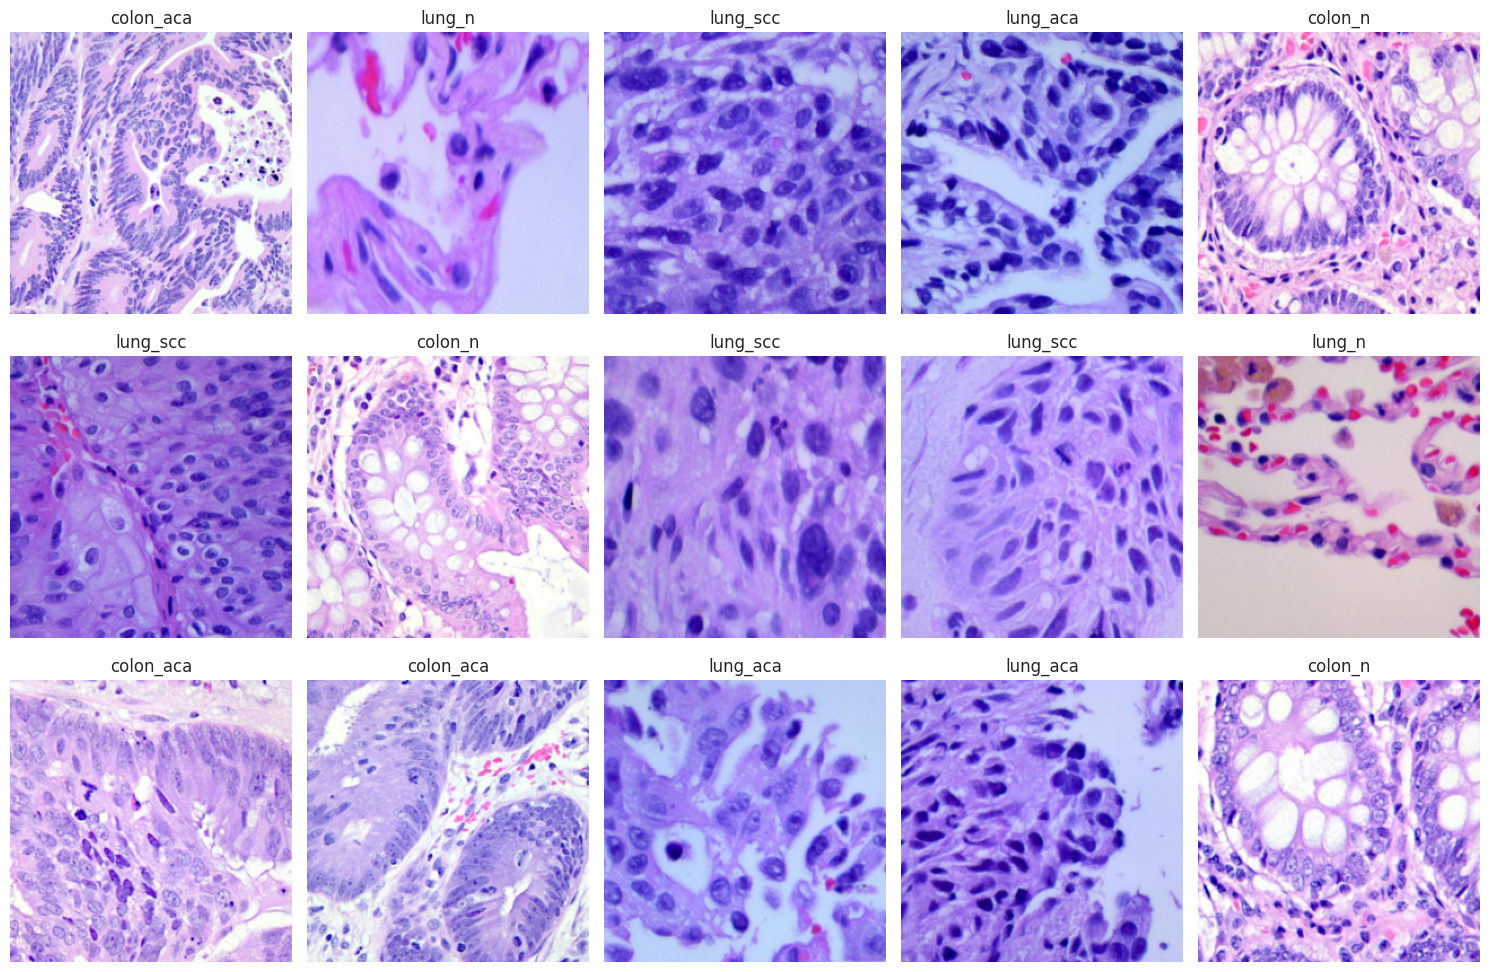

In [24]:
index_to_label = {idx: label for label, idx in label_to_index.items()}


def getlabel(label):
    return index_to_label[label.item()] 

fig, axis = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = train_img_sample[i].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
        ax.imshow(img)
        label = train_label_sample[i]  
        ax.set_title(f"{getlabel(label)}")
        ax.axis('off')

plt.tight_layout() 
plt.show()


In [25]:
test_img_sample, test_label_sample = next(iter(test_dataloader))

label_to_index = {label: idx for idx, label in enumerate(classes)}

test_label_sample = torch.tensor([label_to_index[label] for label in test_label_sample], dtype=torch.long).to(device)

print(f"Image shape: {test_img_sample.shape}")

if isinstance(test_label_sample, torch.Tensor):
    print(f"Label shape: {test_label_sample.shape}")
else:
    print(f"Label length: {len(test_label_sample)}")


Image shape: torch.Size([128, 3, 250, 250])
Label shape: torch.Size([128])


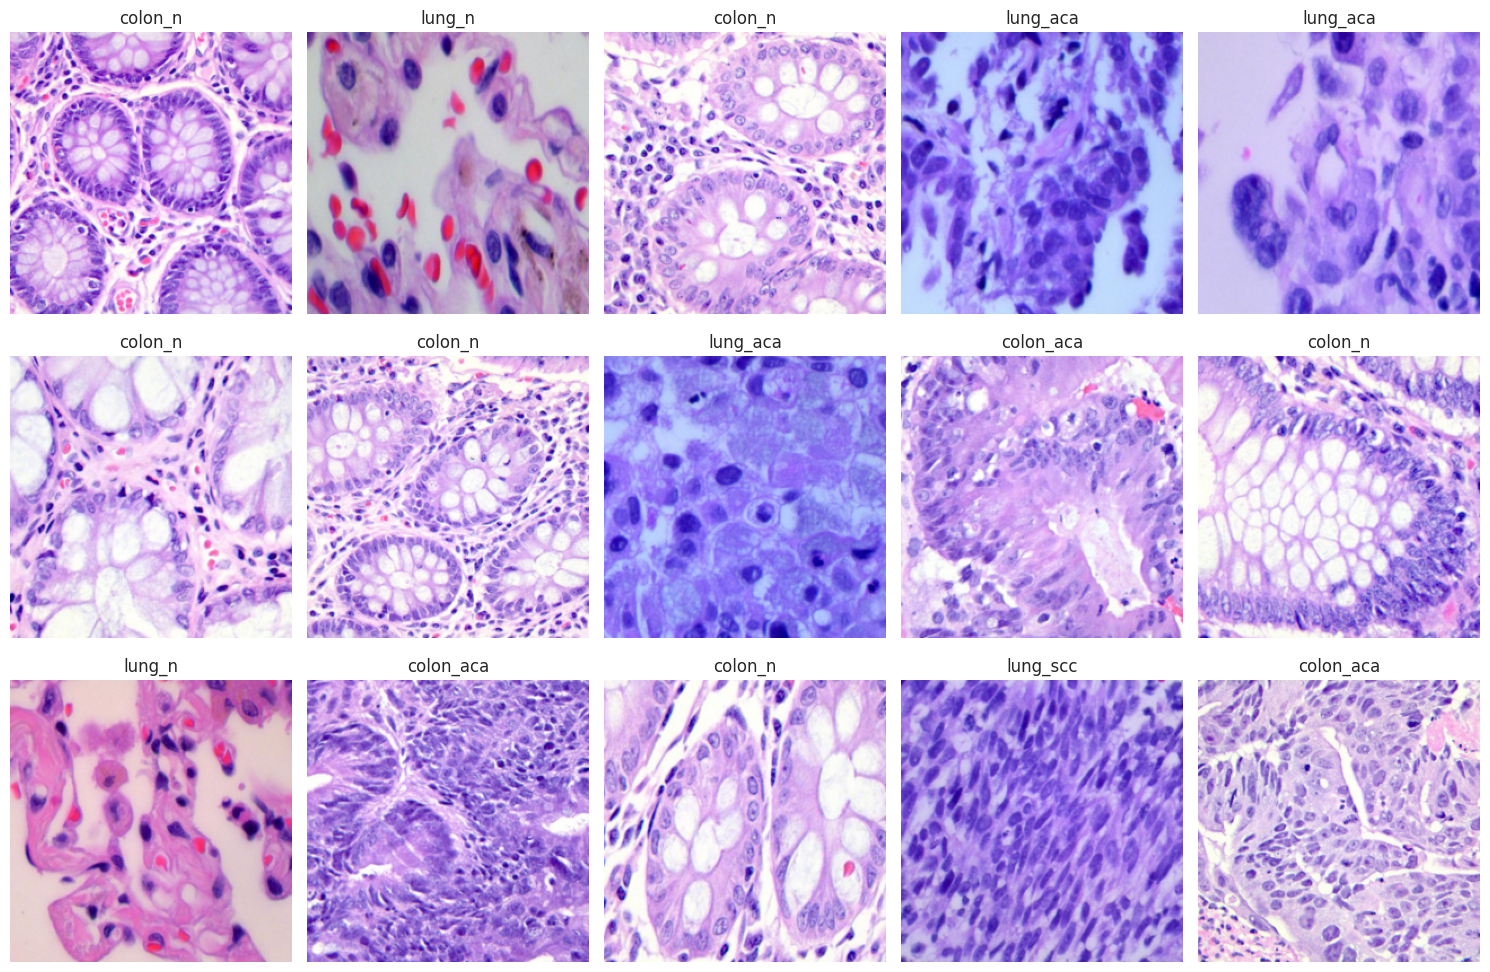

In [26]:
index_to_label = {idx: label for label, idx in label_to_index.items()}


def getlabel(label):
    return index_to_label[label.item()] 

fig, axis = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = test_img_sample[i].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
        ax.imshow(img)
        label = test_label_sample[i]  
        ax.set_title(f"{getlabel(label)}")
        ax.axis('off')

plt.tight_layout() 
plt.show()


In [27]:
class CNN(nn.Module) : 
    def __init__(self,input_shape , output) : 
        super().__init__()
        self.block1=nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape , 
                out_channels=32 , 
                kernel_size=(3,3) , 
                stride=2 , 
                padding = 1 
            ) , 
            
            nn.ReLU() , 
            
            nn.Conv2d(
                in_channels=32 , 
                out_channels=64 , 
                kernel_size=(3,3) , 
                stride=2 , 
                padding=1 
            ) , 
            
            nn.ReLU() , 
            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.block2=nn.Sequential(
            nn.Conv2d(
                in_channels=64 , 
                out_channels=128 , 
                kernel_size=(3,3) , 
                stride = 2 , 
                padding = 1 
            ) , 
            
            nn.ReLU() , 
            
            nn.Conv2d(
                in_channels=128 , 
                out_channels=256 , 
                kernel_size = (3,3) , 
                stride = 2 , 
                padding = 1 
            ) ,
            
            nn.ReLU() , 
            
            nn.MaxPool2d(kernel_size=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512,
                out_channels=1024,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fully_connected_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1024 * 2 * 2, out_features=output) 
        )
        
        
    def forward(self,x) : 
        x=self.block1(x) 
        x=self.block2(x) 
        x=self.block3(x)
        x=self.fully_connected_layer(x)
        return x

In [28]:
torch.manual_seed(42)
model=CNN(
    input_shape = 3 , 
    output=len(classes)
)

In [29]:
model

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_featur

In [30]:

input = (3, 250, 250)
print(summary(model, (input)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 31, 31]          --
|    └─Conv2d: 2-1                       [-1, 32, 125, 125]        896
|    └─ReLU: 2-2                         [-1, 32, 125, 125]        --
|    └─Conv2d: 2-3                       [-1, 64, 63, 63]          18,496
|    └─ReLU: 2-4                         [-1, 64, 63, 63]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 31, 31]          --
├─Sequential: 1-2                        [-1, 256, 4, 4]           --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 256, 8, 8]           295,168
|    └─ReLU: 2-9                         [-1, 256, 8, 8]           --
|    └─MaxPool2d: 2-10                   [-1, 256, 4, 4]           --
├─Sequential: 1-3                        [-1, 1024, 2, 2]          --
|

In [31]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)

In [32]:
model = model.to(device)

epochs = 10 
training_acc = [] 
training_loss = [] 

for epoch in tqdm(range(epochs)): 
    model.train()
    epoch_loss = 0 
    epoch_acc = 0 
    
    for batch, (x_train, y_train) in enumerate(train_dataloader): 
        # Move input data to the correct device
        x_train = x_train.to(device)
        # Convert labels and move to the correct device
        y_train = torch.tensor([label_to_index[label] for label in y_train], 
                               dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x_train)
        
        # Calculate loss
        loss = criterion(y_pred, y_train) 
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        with torch.no_grad():
            batch_acc = (y_pred.argmax(dim=1) == y_train).float().mean().item()
        
        # Accumulate loss and accuracy for the epoch
        epoch_loss += loss.item()
        epoch_acc += batch_acc
    
    # Average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_dataloader)
    avg_acc = epoch_acc / len(train_dataloader)
    
    training_loss.append(avg_loss)
    training_acc.append(avg_acc)
    
    # Print epoch results
    print(f"Epoch {epoch+1}: Accuracy: {avg_acc * 100:.2f}%, Loss: {avg_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Accuracy: 55.36%, Loss: 0.8975
Epoch 2: Accuracy: 85.76%, Loss: 0.3422
Epoch 3: Accuracy: 89.69%, Loss: 0.2596
Epoch 4: Accuracy: 93.54%, Loss: 0.1637
Epoch 5: Accuracy: 95.08%, Loss: 0.1294
Epoch 6: Accuracy: 96.65%, Loss: 0.0867
Epoch 7: Accuracy: 97.03%, Loss: 0.0802
Epoch 8: Accuracy: 96.76%, Loss: 0.0869
Epoch 9: Accuracy: 98.27%, Loss: 0.0465
Epoch 10: Accuracy: 98.79%, Loss: 0.0344


In [33]:
print(f"The loss of the training set is : {training_loss[-1]}")
print(f"The accuracy of the training set is : {training_acc[-1]*100:0.2f}%")

The loss of the training set is : 0.0343516761730692
The accuracy of the training set is : 98.79%


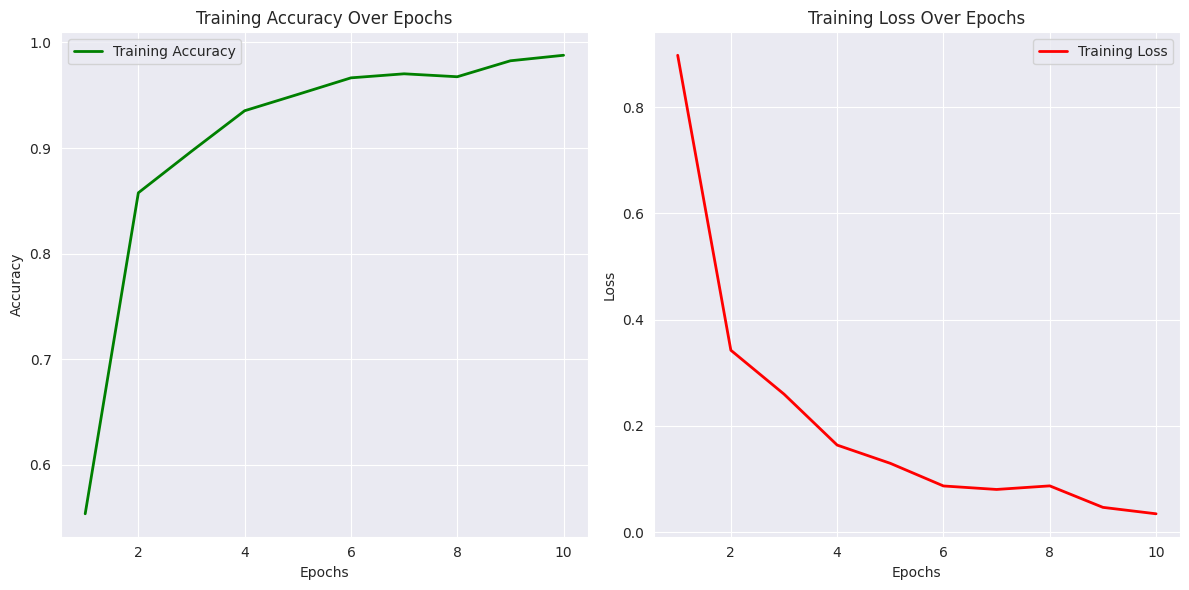

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].plot(range(1, epochs + 1), training_acc, color="green", linewidth=2, label="Training Accuracy")
axes[0].set_title("Training Accuracy Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)


axes[1].plot(range(1, epochs + 1), training_loss, color="red", linewidth=2, label="Training Loss")
axes[1].set_title("Training Loss Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.show()

In [35]:
model.eval()
test_loss = 0
test_acc = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for x_test, y_test in test_dataloader:
        x_test = x_test.to(device)
        y_test = torch.tensor([label_to_index[label] for label in y_test], dtype=torch.long).to(device)

        # Forward pass
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)

        # Calculate accuracy
        batch_acc = (y_pred.argmax(dim=1) == y_test).float().mean().item()
        test_loss += loss.item()
        test_acc += batch_acc

        # Collect predictions and labels for confusion matrix
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Average test loss and accuracy
avg_test_loss = test_loss / len(test_dataloader)
avg_test_acc = test_acc / len(test_dataloader)

print(f"Test Accuracy: {avg_test_acc * 100:.2f}%")
print(f"Test Loss: {avg_test_loss:.4f}")


Test Accuracy: 96.99%
Test Loss: 0.0789


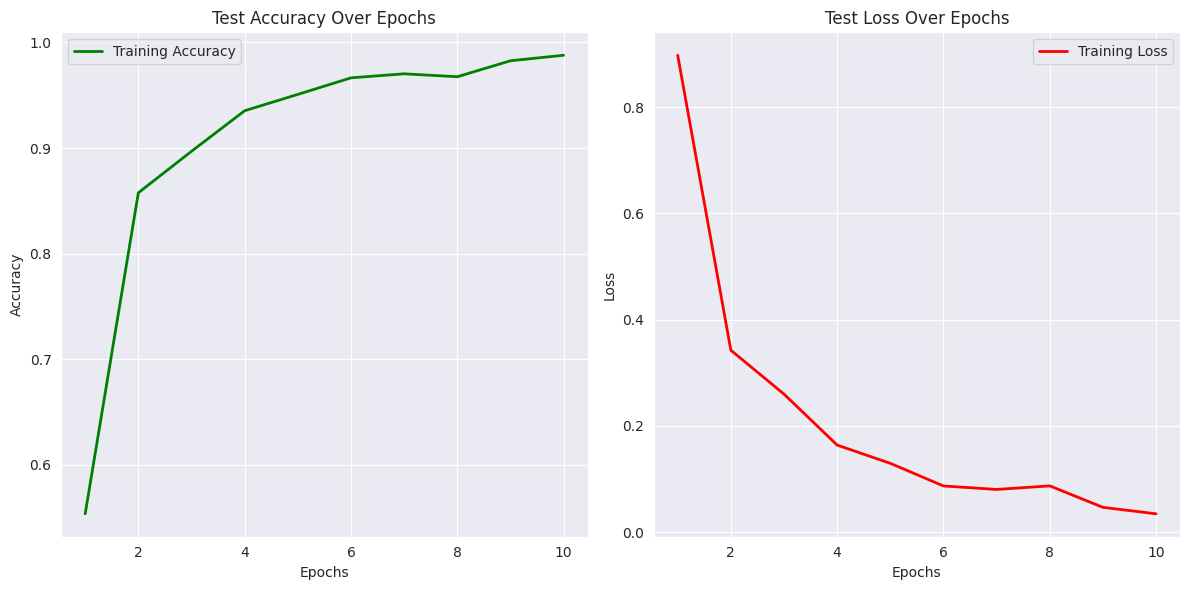

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].plot(range(1, epochs + 1), training_acc, color="green", linewidth=2, label="Training Accuracy")
axes[0].set_title("Test Accuracy Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)


axes[1].plot(range(1, epochs + 1), training_loss, color="red", linewidth=2, label="Training Loss")
axes[1].set_title("Test Loss Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.show()

In [37]:
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Print additional metrics
print(f"Recall: \t{recall}")
print(f"Precision: \t {precision}")
print(f"F1 Score: \t {f1}")

Recall: 	0.9721092091762621
Precision: 	 0.9727373670045377
F1 Score: 	 0.9721827813438543


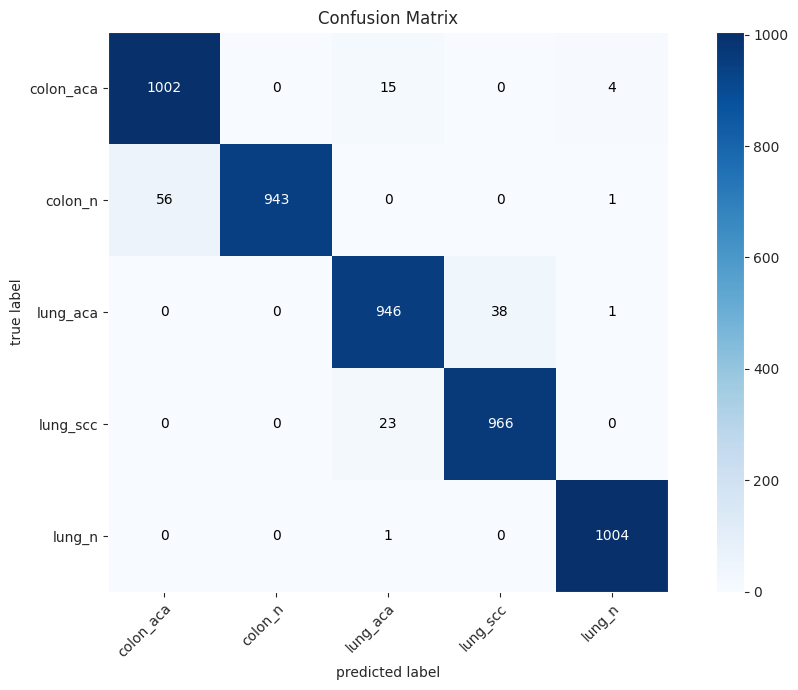

In [38]:
conf = ConfusionMatrix(num_classes=len(classes), task='multiclass')
conf_tensor = conf(torch.tensor(all_preds), torch.tensor(all_labels))
confmat_np = conf_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_np,
    class_names=classes,  
    figsize=(10, 7),
    colorbar=True
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [39]:
torch.save(model.state_dict(), 'lung_colon_cancer_cnn1.pt')